# Assignment: Linear Models
## Do two questions in total: "Q1+Q2" or "Q1+Q3"
### `! git clone https://github.com/ds3001f25/linear_models_assignment.git`

**Q1.** Let's explore multiple linear regression in a two-variable case, to build more intuition about what is happening.

Suppose the model is
$$
\hat{y}_i = b_0 + b_1 z_{i1} + b_2 z_{i2}
$$
Assume that $z_{ij}$ is centered or de-meaned, so that $z_{ij} = x_{ij} - m_j$ where $m_j$ is the mean of variable $j$ and $x_{ij}$ is the original value of variable $j$ for observation $i$. Notice that this implies
$$
\dfrac{1}{N} \sum_{i=1}^N z_{ij} = 0
$$
which will simplify your calculations below substantially!

1. Write down the SSE for this model.
2. Take partial derivatives with respect to $b_0$, $b_1$, and $b_2$.
3. Verify that the average error is zero and $e \cdot z =0$ at the optimum, just as in the single linear regression case.
4. Show that the optimal intercept is $b_0^* = \bar{y}$. Eliminate $b_0^*$ from the remaining equations, and focus on $b_1$ and $b_2$.
5. Write your results as a matrix equation in the form "$Ab=C$". These are called the **normal equations**.
6. Divide both sides by $N$ and substitute $z_{ij} = x_{ij} - m_j$ back into your normal equations for $x_{ij}$. What is the matrix $A$? What is the vector $C$? Explain the intuition of your discovery.

**Q2.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

Q2.1

In [67]:


car_data_path = "https://raw.githubusercontent.com/KendallFreese/linear_models_assignment/main/data/cars_hw.csv"
car_data = pd.read_csv(car_data_path).copy()

# Drop common id
car_data = car_data.drop(columns=car_data.columns.intersection(["Unnamed: 0","id","vin","lot"]), errors="ignore")

# Standardize string columns
obj_cols = car_data.select_dtypes(include="object").columns
if len(obj_cols) > 0:
    car_data.loc[:, obj_cols] = car_data.loc[:, obj_cols].apply(lambda s: s.astype(str).str.strip().str.lower())

# Enforce numeric types
car_data = car_data[pd.to_numeric(car_data.get("Price"), errors="coerce").notna()]
car_data["Price"] = car_data["Price"].astype(float)
car_data = car_data[car_data["Price"] > 0]

car_data = car_data[pd.to_numeric(car_data.get("Make_Year"), errors="coerce").notna()]
car_data["Make_Year"] = car_data["Make_Year"].astype(int)

car_data = car_data[pd.to_numeric(car_data.get("Mileage_Run"), errors="coerce").notna()]
car_data["Mileage_Run"] = car_data["Mileage_Run"].astype(float)
car_data = car_data[car_data["Mileage_Run"] >= 0]

# Age feature
Current_year = 2025
car_data["Age"] = Current_year - car_data["Make_Year"]

# Trim for OLS stability
p_lo, p_hi = car_data["Price"].quantile([0.01, 0.99])
m_lo, m_hi = car_data["Mileage_Run"].quantile([0.01, 0.99])
car_data = car_data[car_data["Price"].between(p_lo, p_hi) & car_data["Mileage_Run"].between(m_lo, m_hi)]

car_data.shape
display(car_data.head(5))


,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price,Age
0,volkswagen,2017,silver,sedan,44611.0,1st,5,diesel,7-speed,automatic,657000.0,8
1,hyundai,2016,red,crossover,20305.0,1st,5,petrol,5-speed,manual,682000.0,9
2,honda,2019,white,suv,29540.0,2nd,5,petrol,5-speed,manual,793000.0,6
3,renault,2017,bronze,hatchback,35680.0,1st,5,petrol,5-speed,manual,414000.0,8
4,hyundai,2017,orange,hatchback,25126.0,1st,5,petrol,5-speed,manual,515000.0,8


Q2.2

,Price
count,9.390000e+02
mean,7.329798e+05
std,3.406993e+05
min,2.710000e+05
25%,4.825000e+05
50%,6.660000e+05
75%,8.790000e+05
90%,1.117000e+06
95%,1.454400e+06
99%,1.897940e+06


,count,mean,std,min,25%,50%,75%,90%,max
Make,,,,,,,,,
mg motors,27.0,1.830333e+06,110937.959100,1589000.0,1767000.0,1822000.0,1958000.0,1978000.0,1978000.0
kia,8.0,1.614750e+06,119056.709177,1369000.0,1579000.0,1628500.0,1705750.0,1717900.0,1741000.0
jeep,4.0,1.499500e+06,152513.387391,1290000.0,1447500.0,1529500.0,1581500.0,1622000.0,1649000.0
mahindra,18.0,1.100167e+06,175549.305961,796000.0,1037000.0,1094500.0,1157000.0,1313600.0,1465000.0
toyota,50.0,8.003400e+05,246689.973986,368000.0,526250.0,894000.0,1023000.0,1051000.0,1092000.0
nissan,3.0,8.103333e+05,304934.965744,475000.0,680000.0,885000.0,978000.0,1033800.0,1071000.0
tata,17.0,1.125647e+06,508878.784827,548000.0,785000.0,871000.0,1685000.0,1889800.0,1972000.0
honda,73.0,7.989726e+05,266509.066586,316000.0,581000.0,785000.0,915000.0,1183600.0,1537000.0
ford,51.0,7.242941e+05,140503.280263,290000.0,639000.0,708000.0,787000.0,935000.0,1066000.0


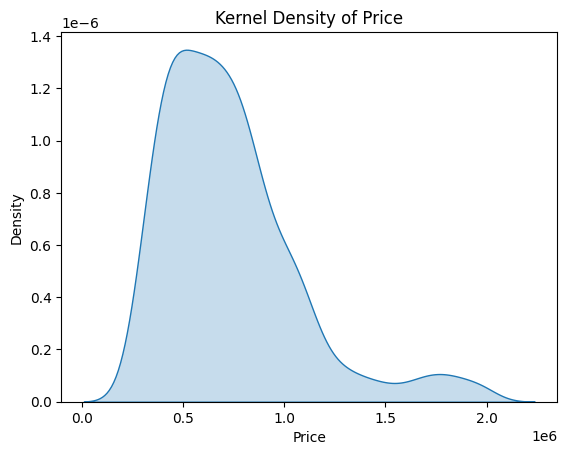

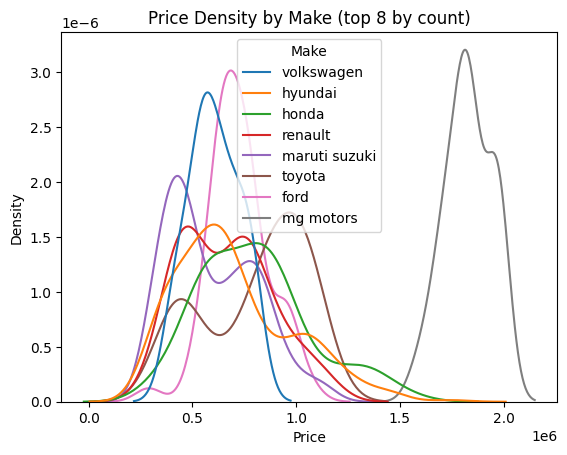

,50%
Make,
mg motors,1822000.0
kia,1628500.0
jeep,1529500.0
mahindra,1094500.0
toyota,894000.0


In [68]:
# Overall Price summary
display(car_data["Price"].describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99]))

# Prices by Make: groupby & describe (sorted by median)
price_by_make = (
    car_data.groupby("Make")["Price"]
            .describe(percentiles=[0.25, 0.50, 0.75, 0.90])
            .sort_values("50%", ascending=False)
)
display(price_by_make.head(10))   # top 10 most expensive

# Kernel density of Price
sns.kdeplot(data=car_data, x="Price", fill=True)
plt.title("Kernel Density of Price"); plt.xlabel("Price"); plt.ylabel("Density"); plt.show()

# Grouped kernel density by Make (using most common makes)
top_makes = car_data["Make"].value_counts().head(8).index
sns.kdeplot(data=car_data[car_data["Make"].isin(top_makes)],
            x="Price", hue="Make", common_norm=False)
plt.title("Price Density by Make (top 8 by count)"); plt.xlabel("Price"); plt.ylabel("Density"); plt.show()

# Most expensive brands (by median)
price_by_make["50%"].head(5)



Mg motors, Kia, Jeep, Mahindra, and Toyota are most expensive. It's important to note htat Kia and Jeep have small sample sizes (8 and 4 respectively, so they should be treated with caution). Looking at the KDE we can see a long upper tail with the majority around 0.4-0.9M and tapering around 2M. The mean of the price values is greater than the median (732,979 compared to 666,000). These prices, if in dollars, are not realistic as normal cars sell from 20,000-100,000 range (I don't want to adjust the data if this is intentional so it's important to note early on).

Q2.3

In [69]:
train = car_data.sample(frac=0.80, random_state=42)
test  = car_data.drop(train.index)

train.shape, test.shape

((751, 12), (188, 12))

Q2.4

In [70]:
# Numeric-only model (Price ~ Mileage_Run & Age)
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

rmse = lambda y, yhat: np.sqrt(np.mean((y - yhat)**2))

ytr, yte = train["Price"].values, test["Price"].values
Xtr_num  = train[["Mileage_Run","Age"]].values
Xte_num  = test[["Mileage_Run","Age"]].values

lin_num = LinearRegression().fit(Xtr_num, ytr)
pred_tr_num = lin_num.predict(Xtr_num)
pred_te_num = lin_num.predict(Xte_num)

r2_tr_num, r2_te_num = lin_num.score(Xtr_num, ytr), lin_num.score(Xte_num, yte)
rmse_tr_num, rmse_te_num = rmse(ytr, pred_tr_num), rmse(yte, pred_te_num)

print(f"[Numeric-only] Train  R^2={r2_tr_num:.3f}  RMSE={rmse_tr_num:,.0f}")
print(f"[Numeric-only] Test   R^2={r2_te_num:.3f}  RMSE={rmse_te_num:,.0f}")


[Numeric-only] Train  R^2=0.303  RMSE=289,334
[Numeric-only] Test   R^2=0.281  RMSE=266,632


In [71]:
# Categorical-only model
cat_cols = train.select_dtypes(include="object").columns

Xtr_cat = pd.get_dummies(train[cat_cols], drop_first=True)
Xte_cat = pd.get_dummies(test[cat_cols],  drop_first=True).reindex(columns=Xtr_cat.columns, fill_value=0)

lin_cat = LinearRegression().fit(Xtr_cat.values, ytr)
pred_te_cat = lin_cat.predict(Xte_cat.values)

r2_te_cat  = lin_cat.score(Xte_cat.values, yte)
rmse_te_cat = rmse(yte, pred_te_cat)

print(f"[Categorical-only] Test R^2={r2_te_cat:.3f}  RMSE={rmse_te_cat:,.0f}")


[Categorical-only] Test R^2=0.738  RMSE=160,881


The categorical-only model performs better on the test set. As it has a higher R^2 value and a lower RMSE which signifies a better fit.

In [72]:
# Joint model (numeric & categorical dummies)
Xtr_joint = pd.concat([train[["Mileage_Run","Age"]].reset_index(drop=True),
                       Xtr_cat.reset_index(drop=True)], axis=1)
Xte_joint = pd.concat([test[["Mileage_Run","Age"]].reset_index(drop=True),
                       Xte_cat.reset_index(drop=True)], axis=1)

lin_joint = LinearRegression().fit(Xtr_joint.values, ytr)
pred_te_joint = lin_joint.predict(Xte_joint.values)

r2_te_joint  = lin_joint.score(Xte_joint.values, yte)
rmse_te_joint = rmse(yte, pred_te_joint)

print(f"[Joint model]  Test R^2={r2_te_joint:.3f}  RMSE={rmse_te_joint:,.0f}")

[Joint model]  Test R^2=0.835  RMSE=127,690


The joint model performs better by a significant amount. The joint moel has an R^2 of 0.835 and RMSE of 127,690. This model has a higher R^2 and lower RMSE than the categorical model (R^2 of 0.738 and RMSE of 160,881) and the numerical model (R^2 of 0.281 and RMSE  of 266,632).

Q2.5

In [73]:
# Polynomial expansion of numeric variables (keeping categorical dummies)

rmse = lambda y, yhat: np.sqrt(np.mean((y - yhat)**2))

degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 18]

rows = []
for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    Xtr_num_poly = poly.fit_transform(train[["Mileage_Run","Age"]].values)
    Xte_num_poly = poly.transform(test[["Mileage_Run","Age"]].values)

# Combine poly numeric & categorical dummies from Q2.4
    Xtr_poly = np.concatenate([Xtr_num_poly, Xtr_cat.values], axis=1)
    Xte_poly = np.concatenate([Xte_num_poly, Xte_cat.values], axis=1)
    lin = LinearRegression().fit(Xtr_poly, ytr)
    yhat_te = lin.predict(Xte_poly)
    rows.append({
        "degree": d,
        "R2_test": lin.score(Xte_poly, yte),
        "RMSE_test": rmse(yte, yhat_te)
    })

summary_poly = pd.DataFrame(rows).sort_values(["R2_test","RMSE_test"], ascending=[False, True])
display(summary_poly)

# Compare best poly model vs best from Q2.4
best_poly = summary_poly.iloc[0]
print(f"Best poly degree = {int(best_poly.degree)} R^2={best_poly.R2_test:.3f} RMSE={best_poly.RMSE_test:,.0f}")
print("Previous best (Q2.4 joint) R^2=0.835 RMSE=127,690")

,degree,R2_test,RMSE_test
1,2,0.836846,127009.306757
0,1,0.835093,127689.641474
2,3,0.310760,261049.018157
3,4,0.264897,269594.317839
4,5,0.204048,280530.569238
5,6,0.150549,289804.953674
6,7,0.111108,296456.694972
7,8,0.083806,300974.968046
8,9,0.065029,304043.575619
9,18,-0.010315,316056.796386


Best poly degree = 2 R^2=0.837 RMSE=127,009
Previous best (Q2.4 joint) R^2=0.835 RMSE=127,690


As you increase the degree of the expansion, the R^2 increases at the highest value of 2 degrees and quickly decreases with each increase in degrees. As the degree increases, RMSE decreases until degree 3 where it then increases with each addtion of a degree. The R^2 goes negative on the test set at degree 18. The best model with expanded features has a R^2 of 0.837 and RMSE of 127,690. This is slightly stronger than the best model from part 4 with a R^2 of 0.835 and RMSE of 127,690.

Q2.6

Test  R^2=0.837   RMSE=127,009


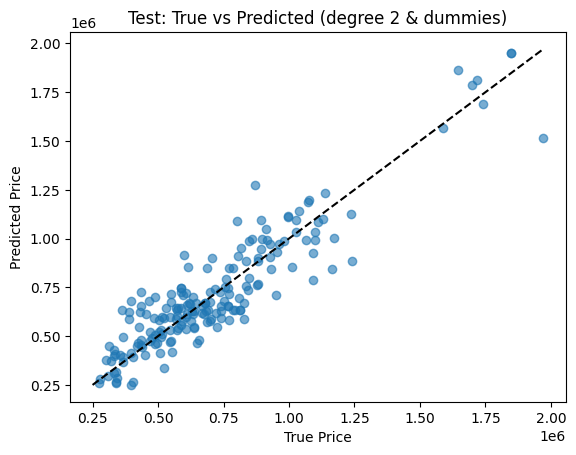

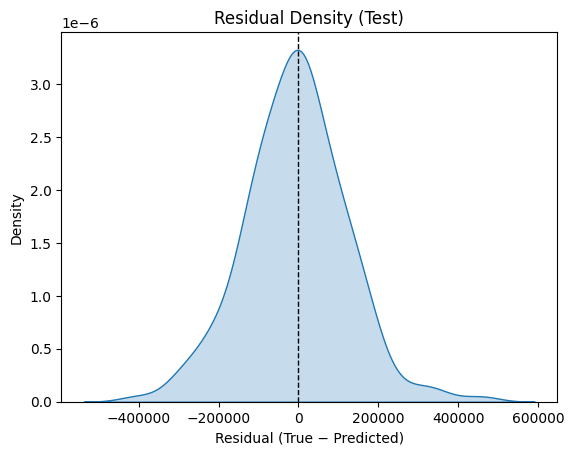

Residual mean: -7,795.14
Residual std:  126,769.87


In [74]:
# Best model (degree = 2 & categorical dummies)

poly2 = PolynomialFeatures(degree=2, include_bias=False)
Xtr_num2 = poly2.fit_transform(train[["Mileage_Run","Age"]].values)
Xte_num2 = poly2.transform(test[["Mileage_Run","Age"]].values)

# Combine polynomial numeric with the dummies from Q2.4
Xtr_best = np.concatenate([Xtr_num2, Xtr_cat.values], axis=1)
Xte_best = np.concatenate([Xte_num2, Xte_cat.values], axis=1)

lin_best = LinearRegression().fit(Xtr_best, ytr)
yhat = lin_best.predict(Xte_best)
res  = yte - yhat

# Metrics
r2_best  = lin_best.score(Xte_best, yte)
rmse_best = np.sqrt(np.mean((yte - yhat)**2))
print(f"Test  R^2={r2_best:.3f}   RMSE={rmse_best:,.0f}")

# Scatter: true vs predicted
lo = float(min(yte.min(), yhat.min()))
hi = float(max(yte.max(), yhat.max()))
plt.figure()
plt.scatter(yte, yhat, alpha=0.6)
plt.plot([lo, hi], [lo, hi], "k--")
plt.xlabel("True Price"); plt.ylabel("Predicted Price")
plt.title("Test: True vs Predicted (degree 2 & dummies)")
plt.show()

# Residual KDE
sns.kdeplot(x=res, fill=True)
plt.axvline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("Residual (True − Predicted)")
plt.title("Residual Density (Test)")
plt.show()

# Residual checks
print(f"Residual mean: {res.mean():,.2f}")
print(f"Residual std:  {res.std():,.2f}")

The predicted values and true values line up along diagonal. The residuals are bell-shaped around zero. The strengths of this model is that it has strong fit with an R^2 of 0.837 and RMSE of 127,009 and its residuals are centered. Some weaknesses of this model is heteroskedasticity is present (error variance increases with price) and there are a few high-price outliers.

**Q3.** This question refers to the `heart_hw.csv` data. It contains three variables:

  - `y`: Whether the individual survived for three years, coded 0 for death and 1 for survival
  - `age`: Patient's age
  - `transplant`: `control` for not receiving a transplant and `treatment` for receiving a transplant

Since a heart transplant is a dangerous operation and even people who successfully get heart transplants might suffer later complications, we want to look at whether a group of transplant recipients tends to survive longer than a comparison group who does not get the procedure.

1. Compute (a) the proportion of people who survive in the control group who do not receive a transplant, and (b) the difference between the proportion of people who survive in the treatment group and the proportion of people who survive in the control group. In a randomized controlled trial, this is called the **average treatment effect**.
2. Regress `y` on `transplant` using a linear model with a constant. How does the constant/intercept of the regression and the coefficient on transplant compare to your answers from part 1? Explain the relationship clearly.
3. We'd like to include `age` in the regression, since it's reasonable to expect that older patients are less likely to survive an extensive surgery like a heart transplant. Regress `y` on a constant, transplant, and age. How does the intercept change?
4. Build a more flexible model that allows for non-linear age effects and interactions between age and treatment. Use a train-test split to validate your model. Estimate your best model, predict the survival probability by age, and plot your results conditional on receiving a transplant and not. Describe what you see.
5. Imagine someone suggests using these kinds of models to select who receives organ transplants; perhaps the CDC or NIH starts using a scoring algorithm to decide who is contacted about a potential organ. What are your concerns about how it is built and how it is deployed?